A.Veekshitha    
2303A52175    
Batch-41   

# Assignment-4

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error

import shap
from lime.lime_tabular import LimeTabularExplainer

RANDOM_STATE = 42
TARGET = "Heating Load"
TEST_SIZE = 0.2
N_ESTIMATORS = 300

DATA_PATH = "/content/ENB2012_data.xlsx"

Load & prepare data

In [ ]:
df = pd.read_excel(DATA_PATH)
df = df.rename(columns={
    "X1":"Relative Compactness","X2":"Surface Area","X3":"Wall Area","X4":"Roof Area",
    "X5":"Overall Height","X6":"Orientation","X7":"Glazing Area","X8":"Glazing Area Distribution",
    "Y1":"Heating Load","Y2":"Cooling Load", "y1":"Heating Load","y2":"Cooling Load"
})

features = [
    "Relative Compactness","Surface Area","Wall Area","Roof Area",
    "Overall Height","Orientation","Glazing Area","Glazing Area Distribution"
]
X = df[features]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

Train model

In [ ]:

rf = RandomForestRegressor(
    n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
y_pred_tr = rf.predict(X_train)
y_pred_te = rf.predict(X_test)
print("Performance:")
print(f"  R2_train: {r2_score(y_train, y_pred_tr):.4f}")
print(f"  R2_test : {r2_score(y_test, y_pred_te):.4f}")
print(f"  MAE_train: {mean_absolute_error(y_train, y_pred_tr):.3f}")
print(f"  MAE_test : {mean_absolute_error(y_test, y_pred_te):.3f}")

Performance:
  R2_train: 0.9997
  R2_test : 0.9977
  MAE_train: 0.114
  MAE_test : 0.352


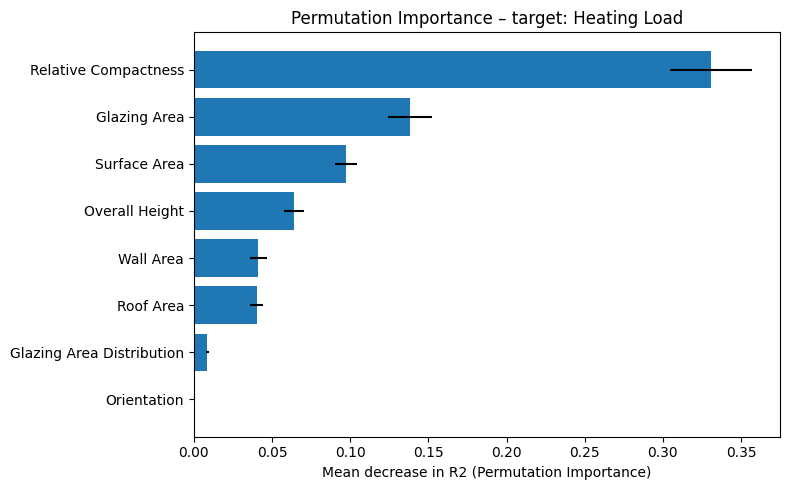

/tmp/ipython-input-559485851.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=features, show=True)


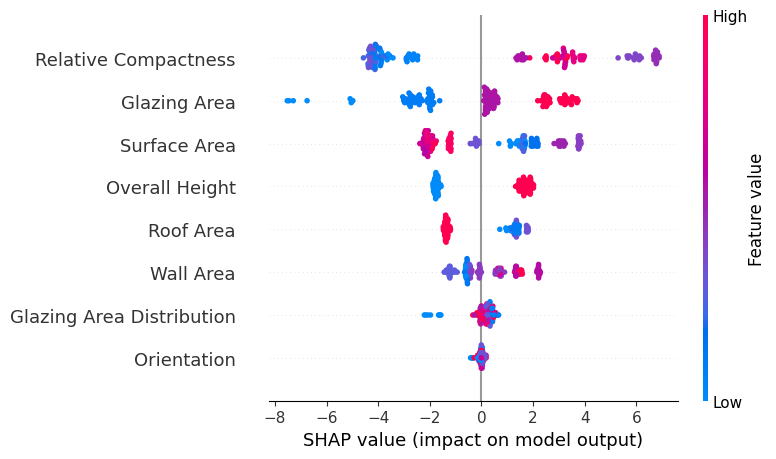

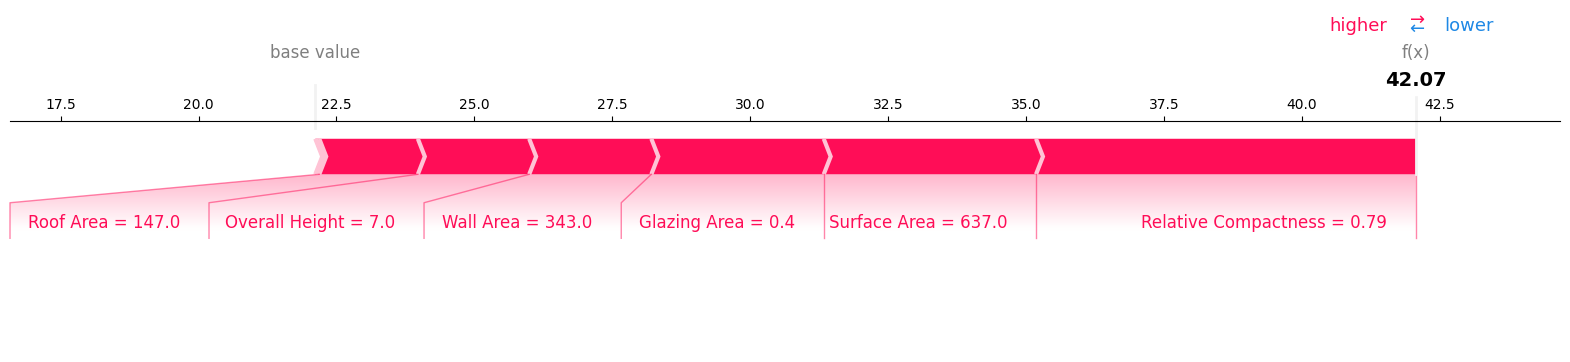

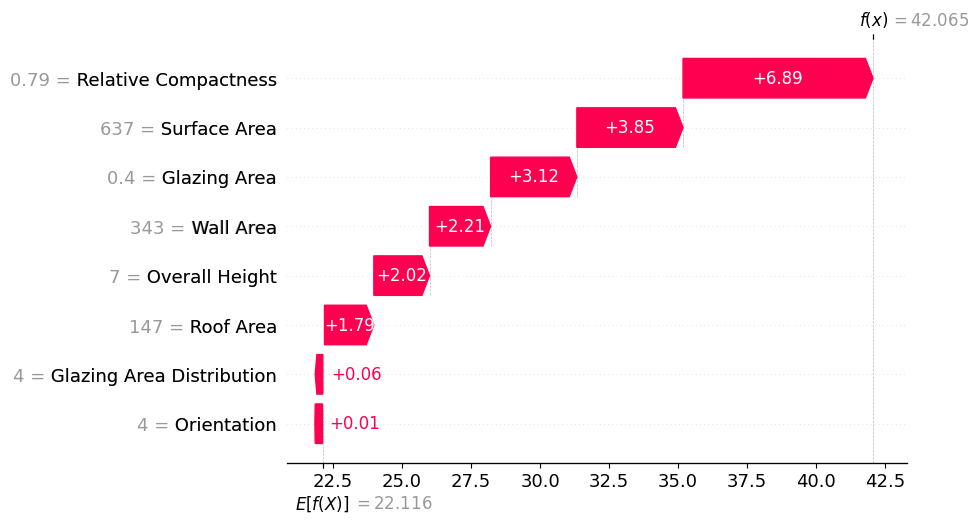

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


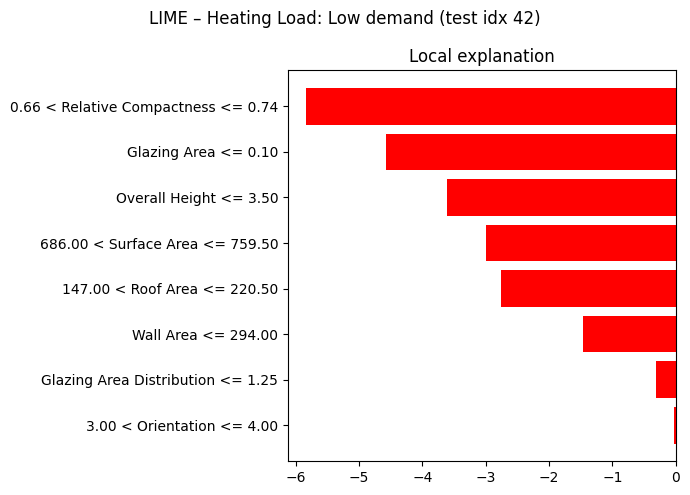

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


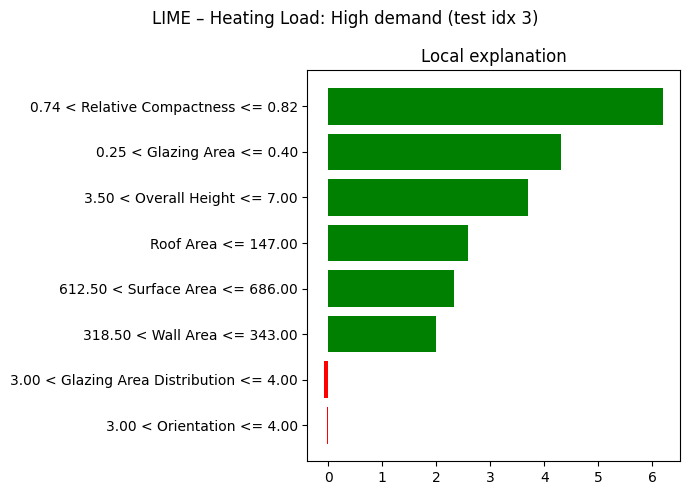


Top-5 features by each method
  PI  : ['Relative Compactness', 'Glazing Area', 'Surface Area', 'Overall Height', 'Wall Area']
  SHAP: ['Relative Compactness', 'Glazing Area', 'Surface Area', 'Overall Height', 'Roof Area']
  Overlap: ['Glazing Area', 'Overall Height', 'Relative Compactness', 'Surface Area']


In [ ]:
# Permutation Importance (PI)
pi = permutation_importance(
    rf, X_test, y_test, n_repeats=15, random_state=RANDOM_STATE, n_jobs=-1
)
order = np.argsort(pi.importances_mean)
plt.figure(figsize=(8,5))
plt.barh(np.array(features)[order], pi.importances_mean[order], xerr=pi.importances_std[order])
plt.xlabel("Mean decrease in R2 (Permutation Importance)")
plt.title(f"Permutation Importance – target: {TARGET}")
plt.tight_layout()
plt.show()

# SHAP: Global + Local
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Global summary plot
shap.summary_plot(shap_values, X_test, feature_names=features, show=True)

preds = rf.predict(X_test)
low_idx = int(np.argmin(preds))
high_idx = int(np.argmax(preds))

try:
    # Force plot
    shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values[high_idx],
        features=X_test.iloc[high_idx],
        feature_names=features,
        matplotlib=True
    )
except Exception:
    pass

# Waterfall plots
try:
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[high_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[high_idx].values,
        feature_names=features
    ), show=True)
except Exception:
    vals = np.abs(shap_values[high_idx])
    order_local = np.argsort(vals)
    plt.figure(figsize=(7,4))
    plt.barh(np.array(features)[order_local], vals[order_local])
    plt.title(f"Local SHAP (|value|) – High {TARGET} (idx {high_idx})")
    plt.tight_layout()
    plt.show()

# LIME
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    discretize_continuous=True,
    mode="regression",
    random_state=RANDOM_STATE
)
for tag, i in [("Low demand", low_idx), ("High demand", high_idx)]:
    exp = lime_explainer.explain_instance(
        data_row=X_test.iloc[i].values,
        predict_fn=rf.predict,
        num_features=min(8, X_train.shape[1])
    )
    fig = exp.as_pyplot_figure()
    fig.set_size_inches(7, 5)
    fig.suptitle(f"LIME – {TARGET}: {tag} (test idx {i})")
    plt.tight_layout()
    plt.show()

# Compare PI vs SHAP (top-5)
top_k = 5
top_pi_idx = np.argsort(pi.importances_mean)[::-1][:top_k]
top_pi = [features[i] for i in top_pi_idx]

mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_shap_idx = np.argsort(mean_abs_shap)[::-1][:top_k]
top_shap = [features[i] for i in top_shap_idx]

print("\nTop-5 features by each method")
print("  PI  :", top_pi)
print("  SHAP:", top_shap)

overlap = sorted(set(top_pi) & set(top_shap))
print("  Overlap:", overlap if overlap else "None")
